# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle



# Importing Libraries

In [1]:
%matplotlib inline

import os
import torch
import random
import torchvision
import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.6.0+cu101


# Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Creating Custom Dataset

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name])[:300] if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    def __getitem__(self, index):
        all_images = self.images[self.class_names[0]] \
          + self.images[self.class_names[1]] \
          + self.images[self.class_names[2]]
        all_class_names = [self.class_names[0]]*len(self.images[self.class_names[0]]) \
          + [self.class_names[1]]*len(self.images[self.class_names[1]]) \
          + [self.class_names[2]]*len(self.images[self.class_names[2]])
        image_name = all_images[index]
        class_name = all_class_names[index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [5]:
train_dirs = {
    'normal': 'drive/My Drive/dataset/COVID-19 Radiography Database/normal',
    'viral': 'drive/My Drive/dataset/COVID-19 Radiography Database/viral',
    'covid': 'drive/My Drive/dataset/COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, transform)

Found 300 normal examples
Found 300 viral examples
Found 159 covid examples


In [6]:
dev_dirs = {
    'normal': 'drive/My Drive/dataset/COVID-19 Radiography Database/dev/normal',
    'viral': 'drive/My Drive/dataset/COVID-19 Radiography Database/dev/viral',
    'covid': 'drive/My Drive/dataset/COVID-19 Radiography Database/dev/covid'
}

dev_dataset = ChestXRayDataset(dev_dirs, transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [7]:
test_dirs = {
    'normal': 'drive/My Drive/dataset/COVID-19 Radiography Database/test/normal',
    'viral': 'drive/My Drive/dataset/COVID-19 Radiography Database/test/viral',
    'covid': 'drive/My Drive/dataset/COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [8]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_dev = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of dev batches', len(dl_dev))
print('Number of test batches', len(dl_test))

Number of training batches 127
Number of dev batches 15
Number of test batches 15


# Data Visualization

In [34]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'red' if preds[i] != labels[i] else 'green'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

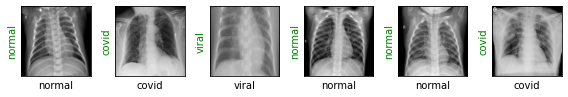

In [12]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

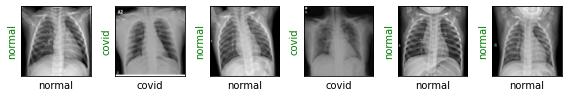

In [13]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [14]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

- Reference model

In [32]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

- Model with dropout in the last layer

In [31]:
# Add dropout: 
# # https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
resnet18.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=512, out_features=3),
    torch.nn.Dropout(0.5)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

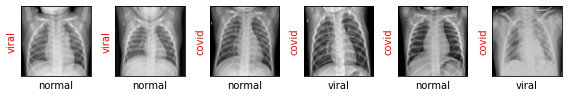

In [35]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_dev))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

show_preds()

# Training the Model

In [40]:
train_losses = []
dev_losses = []
train_accuracies = []
dev_accuracies = []
def train(epochs):
    print('Training started.')
    for epoch in range(epochs):
        print('='*20)
        print('Starting epoch %d/%d' % (epoch + 1, epochs))
        print('='*20)

        train_accuracy = 0.
        train_loss = 0.
        # Model training
        resnet18.train() # set model to training phase
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            train_accuracy += sum((preds == labels).numpy())

            print('%d/%d: Batch train Loss: %.4f' % 
                  (train_step, len(dl_train), train_loss))
        
        train_loss /= (train_step + 1)
        train_losses.append(train_loss)
        train_accuracy = train_accuracy / len(train_dataset)
        train_accuracies.append(train_accuracy)
        print('Train Loss: %.4f, Accuracy: %.4f' % (train_loss, train_accuracy))

        # Model validation on dev set
        dev_accuracy = 0
        dev_loss = 0.
        resnet18.eval() # set model to eval phase
        for val_step, (images, labels) in enumerate(dl_dev):
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            dev_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            dev_accuracy += sum((preds == labels).numpy())

        dev_loss /= (val_step + 1)
        dev_losses.append(dev_loss)
        dev_accuracy = dev_accuracy / len(dev_dataset)
        dev_accuracies.append(dev_accuracy)
        print('Dev Loss: %.4f, Accuracy: %.4f' % (dev_loss, dev_accuracy))

        show_preds()
        resnet18.train() # set model to training phase
        
    print('Training complete.')

Training started.
Starting epoch 1/20
0/127: Batch train Loss: 0.3015
1/127: Batch train Loss: 0.3358
2/127: Batch train Loss: 0.4158
3/127: Batch train Loss: 0.7207
4/127: Batch train Loss: 0.7692
5/127: Batch train Loss: 0.7795
6/127: Batch train Loss: 0.8031
7/127: Batch train Loss: 0.8952
8/127: Batch train Loss: 1.1449
9/127: Batch train Loss: 1.2112
10/127: Batch train Loss: 1.2938
11/127: Batch train Loss: 1.6098
12/127: Batch train Loss: 1.9077
13/127: Batch train Loss: 1.9163
14/127: Batch train Loss: 2.0249
15/127: Batch train Loss: 2.0463
16/127: Batch train Loss: 2.0669
17/127: Batch train Loss: 2.1037
18/127: Batch train Loss: 2.1952
19/127: Batch train Loss: 2.6409
20/127: Batch train Loss: 2.7034
21/127: Batch train Loss: 2.8561
22/127: Batch train Loss: 2.8904
23/127: Batch train Loss: 2.9082
24/127: Batch train Loss: 3.0461
25/127: Batch train Loss: 3.0635
26/127: Batch train Loss: 3.5903
27/127: Batch train Loss: 3.6488
28/127: Batch train Loss: 3.8293
29/127: Batch t

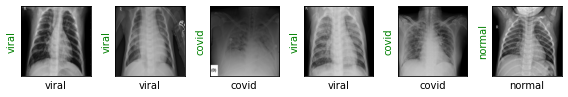

Starting epoch 2/20
0/127: Batch train Loss: 0.0110
1/127: Batch train Loss: 0.0239
2/127: Batch train Loss: 0.0626
3/127: Batch train Loss: 0.4590
4/127: Batch train Loss: 0.4996
5/127: Batch train Loss: 0.5312
6/127: Batch train Loss: 0.7427
7/127: Batch train Loss: 0.9809
8/127: Batch train Loss: 0.9867
9/127: Batch train Loss: 0.9905
10/127: Batch train Loss: 1.0037
11/127: Batch train Loss: 1.0541
12/127: Batch train Loss: 1.0745
13/127: Batch train Loss: 1.0862
14/127: Batch train Loss: 1.1000
15/127: Batch train Loss: 1.1079
16/127: Batch train Loss: 1.1241
17/127: Batch train Loss: 1.2192
18/127: Batch train Loss: 1.8664
19/127: Batch train Loss: 1.9075
20/127: Batch train Loss: 1.9336
21/127: Batch train Loss: 2.8335
22/127: Batch train Loss: 2.8626
23/127: Batch train Loss: 3.3703
24/127: Batch train Loss: 3.5449
25/127: Batch train Loss: 3.5799
26/127: Batch train Loss: 5.1400
27/127: Batch train Loss: 5.1809
28/127: Batch train Loss: 5.2231
29/127: Batch train Loss: 5.2517


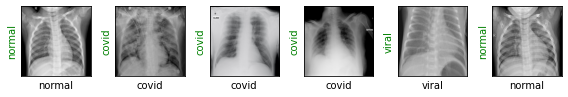

Starting epoch 3/20
0/127: Batch train Loss: 0.0113
1/127: Batch train Loss: 0.1386
2/127: Batch train Loss: 0.1442
3/127: Batch train Loss: 0.1665
4/127: Batch train Loss: 0.2178
5/127: Batch train Loss: 0.2819
6/127: Batch train Loss: 0.6684
7/127: Batch train Loss: 0.8129
8/127: Batch train Loss: 0.8432
9/127: Batch train Loss: 0.8790
10/127: Batch train Loss: 0.8830
11/127: Batch train Loss: 0.9117
12/127: Batch train Loss: 0.9900
13/127: Batch train Loss: 0.9926
14/127: Batch train Loss: 1.0254
15/127: Batch train Loss: 1.2995
16/127: Batch train Loss: 1.3028
17/127: Batch train Loss: 1.3190
18/127: Batch train Loss: 1.3508
19/127: Batch train Loss: 1.8472
20/127: Batch train Loss: 1.8625
21/127: Batch train Loss: 1.8983
22/127: Batch train Loss: 2.1406
23/127: Batch train Loss: 2.1541
24/127: Batch train Loss: 2.1665
25/127: Batch train Loss: 2.1766
26/127: Batch train Loss: 2.2022
27/127: Batch train Loss: 2.2067
28/127: Batch train Loss: 2.2487
29/127: Batch train Loss: 2.2548


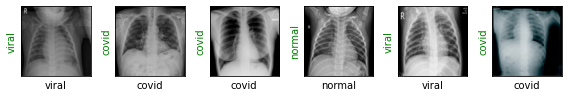

Starting epoch 4/20
0/127: Batch train Loss: 0.0034
1/127: Batch train Loss: 0.0148
2/127: Batch train Loss: 0.0331
3/127: Batch train Loss: 0.0474
4/127: Batch train Loss: 0.0579
5/127: Batch train Loss: 0.0833
6/127: Batch train Loss: 0.1554
7/127: Batch train Loss: 0.1594
8/127: Batch train Loss: 0.1665
9/127: Batch train Loss: 0.2020
10/127: Batch train Loss: 0.2692
11/127: Batch train Loss: 0.3052
12/127: Batch train Loss: 0.3303
13/127: Batch train Loss: 0.3415
14/127: Batch train Loss: 0.3486
15/127: Batch train Loss: 0.3551
16/127: Batch train Loss: 0.3600
17/127: Batch train Loss: 0.4668
18/127: Batch train Loss: 0.4746
19/127: Batch train Loss: 0.5061
20/127: Batch train Loss: 0.5244
21/127: Batch train Loss: 0.5460
22/127: Batch train Loss: 0.5485
23/127: Batch train Loss: 0.5871
24/127: Batch train Loss: 0.6311
25/127: Batch train Loss: 0.7841
26/127: Batch train Loss: 0.8196
27/127: Batch train Loss: 0.8305
28/127: Batch train Loss: 1.0575
29/127: Batch train Loss: 1.0720


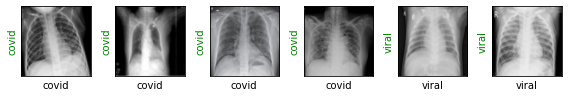

Starting epoch 5/20
0/127: Batch train Loss: 0.0026
1/127: Batch train Loss: 0.3395
2/127: Batch train Loss: 0.3465
3/127: Batch train Loss: 0.5078
4/127: Batch train Loss: 0.5702
5/127: Batch train Loss: 0.5723
6/127: Batch train Loss: 0.5867
7/127: Batch train Loss: 0.5920
8/127: Batch train Loss: 0.7159
9/127: Batch train Loss: 0.7215
10/127: Batch train Loss: 0.7423
11/127: Batch train Loss: 0.7569
12/127: Batch train Loss: 0.7642
13/127: Batch train Loss: 0.7664
14/127: Batch train Loss: 0.7703
15/127: Batch train Loss: 0.7835
16/127: Batch train Loss: 0.7940
17/127: Batch train Loss: 0.8451
18/127: Batch train Loss: 0.8521
19/127: Batch train Loss: 0.8723
20/127: Batch train Loss: 0.8949
21/127: Batch train Loss: 0.9295
22/127: Batch train Loss: 0.9398
23/127: Batch train Loss: 0.9431
24/127: Batch train Loss: 0.9728
25/127: Batch train Loss: 0.9814
26/127: Batch train Loss: 0.9989
27/127: Batch train Loss: 1.0467
28/127: Batch train Loss: 1.0640
29/127: Batch train Loss: 1.0838


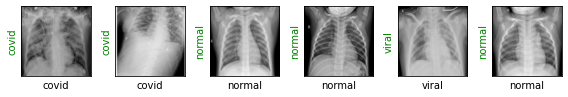

Starting epoch 6/20
0/127: Batch train Loss: 0.0295
1/127: Batch train Loss: 0.0407
2/127: Batch train Loss: 0.0822
3/127: Batch train Loss: 0.0862
4/127: Batch train Loss: 0.1029
5/127: Batch train Loss: 0.1117
6/127: Batch train Loss: 0.1143
7/127: Batch train Loss: 0.1283
8/127: Batch train Loss: 0.1370
9/127: Batch train Loss: 0.1812
10/127: Batch train Loss: 0.1832
11/127: Batch train Loss: 0.1853
12/127: Batch train Loss: 0.1961
13/127: Batch train Loss: 0.1982
14/127: Batch train Loss: 0.2014
15/127: Batch train Loss: 0.2105
16/127: Batch train Loss: 0.2572
17/127: Batch train Loss: 0.2602
18/127: Batch train Loss: 0.2674
19/127: Batch train Loss: 0.2780
20/127: Batch train Loss: 0.2822
21/127: Batch train Loss: 0.2909
22/127: Batch train Loss: 0.3016
23/127: Batch train Loss: 0.3103
24/127: Batch train Loss: 0.3320
25/127: Batch train Loss: 0.3339
26/127: Batch train Loss: 0.3448
27/127: Batch train Loss: 0.3466
28/127: Batch train Loss: 0.8312
29/127: Batch train Loss: 0.8614


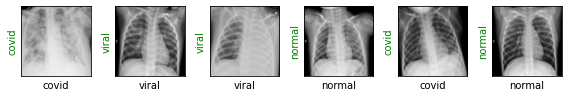

Starting epoch 7/20
0/127: Batch train Loss: 0.0069
1/127: Batch train Loss: 0.0102
2/127: Batch train Loss: 0.0123
3/127: Batch train Loss: 0.0152
4/127: Batch train Loss: 0.0815
5/127: Batch train Loss: 0.0823
6/127: Batch train Loss: 0.0839
7/127: Batch train Loss: 0.0913
8/127: Batch train Loss: 0.1216
9/127: Batch train Loss: 0.2270
10/127: Batch train Loss: 0.2566
11/127: Batch train Loss: 0.3074
12/127: Batch train Loss: 0.3805
13/127: Batch train Loss: 0.3957
14/127: Batch train Loss: 0.4188
15/127: Batch train Loss: 0.4345
16/127: Batch train Loss: 0.4939
17/127: Batch train Loss: 0.5022
18/127: Batch train Loss: 0.5040
19/127: Batch train Loss: 0.5382
20/127: Batch train Loss: 0.5441
21/127: Batch train Loss: 0.5473
22/127: Batch train Loss: 0.6531
23/127: Batch train Loss: 0.6561
24/127: Batch train Loss: 0.6662
25/127: Batch train Loss: 0.6685
26/127: Batch train Loss: 0.6807
27/127: Batch train Loss: 0.6966
28/127: Batch train Loss: 0.7229
29/127: Batch train Loss: 0.7253


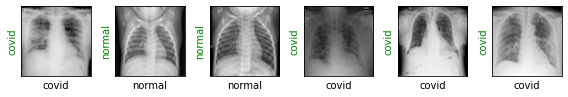

Starting epoch 8/20
0/127: Batch train Loss: 0.0027
1/127: Batch train Loss: 0.0559
2/127: Batch train Loss: 0.0631
3/127: Batch train Loss: 0.1215
4/127: Batch train Loss: 0.1231
5/127: Batch train Loss: 0.1450
6/127: Batch train Loss: 0.1466
7/127: Batch train Loss: 0.1490
8/127: Batch train Loss: 0.1563
9/127: Batch train Loss: 0.1579
10/127: Batch train Loss: 0.1596
11/127: Batch train Loss: 0.1616
12/127: Batch train Loss: 0.1704
13/127: Batch train Loss: 0.4046
14/127: Batch train Loss: 0.4124
15/127: Batch train Loss: 0.4746
16/127: Batch train Loss: 0.5023
17/127: Batch train Loss: 0.5099
18/127: Batch train Loss: 0.5115
19/127: Batch train Loss: 0.5187
20/127: Batch train Loss: 0.5195
21/127: Batch train Loss: 0.5215
22/127: Batch train Loss: 0.5222
23/127: Batch train Loss: 0.5250
24/127: Batch train Loss: 0.5445
25/127: Batch train Loss: 0.5488
26/127: Batch train Loss: 0.6291
27/127: Batch train Loss: 0.6645
28/127: Batch train Loss: 0.6706
29/127: Batch train Loss: 0.6715


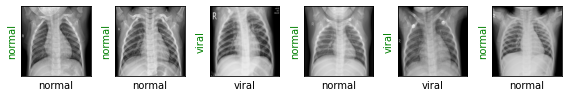

Starting epoch 9/20
0/127: Batch train Loss: 0.0023
1/127: Batch train Loss: 0.0035
2/127: Batch train Loss: 0.0660
3/127: Batch train Loss: 0.0696
4/127: Batch train Loss: 0.0737
5/127: Batch train Loss: 0.1073
6/127: Batch train Loss: 0.1094
7/127: Batch train Loss: 0.1162
8/127: Batch train Loss: 0.1209
9/127: Batch train Loss: 0.1237
10/127: Batch train Loss: 0.2020
11/127: Batch train Loss: 0.2053
12/127: Batch train Loss: 0.2072
13/127: Batch train Loss: 0.2111
14/127: Batch train Loss: 0.3475
15/127: Batch train Loss: 0.3508
16/127: Batch train Loss: 0.3565
17/127: Batch train Loss: 0.3585
18/127: Batch train Loss: 0.3645
19/127: Batch train Loss: 0.3706
20/127: Batch train Loss: 0.4533
21/127: Batch train Loss: 0.4614
22/127: Batch train Loss: 0.4622
23/127: Batch train Loss: 0.4713
24/127: Batch train Loss: 0.4737
25/127: Batch train Loss: 0.4803
26/127: Batch train Loss: 0.5112
27/127: Batch train Loss: 0.5131
28/127: Batch train Loss: 0.5227
29/127: Batch train Loss: 0.5305


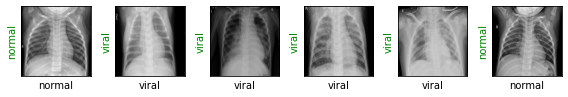

Starting epoch 10/20
0/127: Batch train Loss: 0.0043
1/127: Batch train Loss: 0.0051
2/127: Batch train Loss: 0.0060
3/127: Batch train Loss: 0.1774
4/127: Batch train Loss: 0.1829
5/127: Batch train Loss: 0.1856
6/127: Batch train Loss: 0.1862
7/127: Batch train Loss: 0.1895
8/127: Batch train Loss: 0.1933
9/127: Batch train Loss: 0.1979
10/127: Batch train Loss: 0.2010
11/127: Batch train Loss: 0.2199
12/127: Batch train Loss: 0.2214
13/127: Batch train Loss: 0.2222
14/127: Batch train Loss: 0.2234
15/127: Batch train Loss: 0.2323
16/127: Batch train Loss: 0.3498
17/127: Batch train Loss: 0.3567
18/127: Batch train Loss: 0.3578
19/127: Batch train Loss: 0.3643
20/127: Batch train Loss: 0.3658
21/127: Batch train Loss: 0.3693
22/127: Batch train Loss: 0.4203
23/127: Batch train Loss: 0.4523
24/127: Batch train Loss: 0.4571
25/127: Batch train Loss: 0.4618
26/127: Batch train Loss: 0.4674
27/127: Batch train Loss: 0.5028
28/127: Batch train Loss: 0.5084
29/127: Batch train Loss: 0.5121

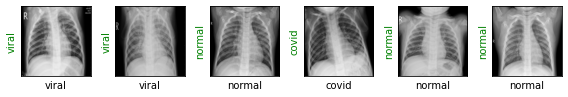

Starting epoch 11/20
0/127: Batch train Loss: 0.0012
1/127: Batch train Loss: 0.0029
2/127: Batch train Loss: 0.0054
3/127: Batch train Loss: 0.0724
4/127: Batch train Loss: 0.0751
5/127: Batch train Loss: 0.0774
6/127: Batch train Loss: 0.0792
7/127: Batch train Loss: 0.0838
8/127: Batch train Loss: 0.0848
9/127: Batch train Loss: 0.0862
10/127: Batch train Loss: 0.1366
11/127: Batch train Loss: 0.1396
12/127: Batch train Loss: 0.1407
13/127: Batch train Loss: 0.1633
14/127: Batch train Loss: 0.1764
15/127: Batch train Loss: 0.1790
16/127: Batch train Loss: 0.1803
17/127: Batch train Loss: 0.1818
18/127: Batch train Loss: 0.1856
19/127: Batch train Loss: 0.1863
20/127: Batch train Loss: 0.1928
21/127: Batch train Loss: 0.1936
22/127: Batch train Loss: 0.1974
23/127: Batch train Loss: 0.3260
24/127: Batch train Loss: 0.3265
25/127: Batch train Loss: 0.3278
26/127: Batch train Loss: 0.3337
27/127: Batch train Loss: 0.3377
28/127: Batch train Loss: 0.3441
29/127: Batch train Loss: 0.3470

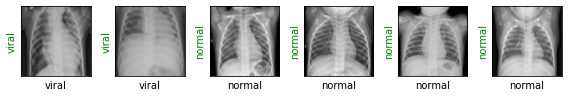

Starting epoch 12/20
0/127: Batch train Loss: 0.0453
1/127: Batch train Loss: 0.0487
2/127: Batch train Loss: 0.0502
3/127: Batch train Loss: 0.0509
4/127: Batch train Loss: 0.0513
5/127: Batch train Loss: 0.0547
6/127: Batch train Loss: 0.0674
7/127: Batch train Loss: 0.0687
8/127: Batch train Loss: 0.0726
9/127: Batch train Loss: 0.0731
10/127: Batch train Loss: 0.0737
11/127: Batch train Loss: 0.0748
12/127: Batch train Loss: 0.0758
13/127: Batch train Loss: 0.0766
14/127: Batch train Loss: 0.0770
15/127: Batch train Loss: 0.0780
16/127: Batch train Loss: 0.0817
17/127: Batch train Loss: 0.0854
18/127: Batch train Loss: 0.0898
19/127: Batch train Loss: 0.0941
20/127: Batch train Loss: 0.1021
21/127: Batch train Loss: 0.1030
22/127: Batch train Loss: 0.1102
23/127: Batch train Loss: 0.1151
24/127: Batch train Loss: 0.1167
25/127: Batch train Loss: 0.1204
26/127: Batch train Loss: 0.1981
27/127: Batch train Loss: 0.2004
28/127: Batch train Loss: 0.2059
29/127: Batch train Loss: 0.2445

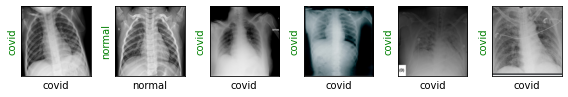

Starting epoch 13/20
0/127: Batch train Loss: 0.1011
1/127: Batch train Loss: 0.1018
2/127: Batch train Loss: 0.1045
3/127: Batch train Loss: 0.1168
4/127: Batch train Loss: 0.1408
5/127: Batch train Loss: 0.2047
6/127: Batch train Loss: 0.2277
7/127: Batch train Loss: 0.2720
8/127: Batch train Loss: 0.2834
9/127: Batch train Loss: 0.2930
10/127: Batch train Loss: 0.3172
11/127: Batch train Loss: 0.3991
12/127: Batch train Loss: 0.4232
13/127: Batch train Loss: 0.4494
14/127: Batch train Loss: 0.4611
15/127: Batch train Loss: 0.4633
16/127: Batch train Loss: 0.4699
17/127: Batch train Loss: 0.4717
18/127: Batch train Loss: 0.4944
19/127: Batch train Loss: 0.5040
20/127: Batch train Loss: 0.5050
21/127: Batch train Loss: 0.5064
22/127: Batch train Loss: 0.5198
23/127: Batch train Loss: 0.5922
24/127: Batch train Loss: 0.5949
25/127: Batch train Loss: 0.5958
26/127: Batch train Loss: 0.6004
27/127: Batch train Loss: 0.6010
28/127: Batch train Loss: 0.6115
29/127: Batch train Loss: 0.6208

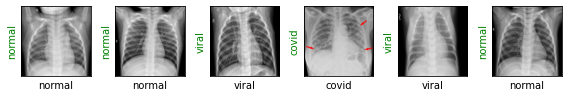

Starting epoch 14/20
0/127: Batch train Loss: 0.0031
1/127: Batch train Loss: 0.0082
2/127: Batch train Loss: 0.0128
3/127: Batch train Loss: 0.0188
4/127: Batch train Loss: 0.0253
5/127: Batch train Loss: 0.0363
6/127: Batch train Loss: 0.0387
7/127: Batch train Loss: 0.2775
8/127: Batch train Loss: 0.2887
9/127: Batch train Loss: 0.2957
10/127: Batch train Loss: 0.3207
11/127: Batch train Loss: 0.3247
12/127: Batch train Loss: 0.3371
13/127: Batch train Loss: 0.3386
14/127: Batch train Loss: 0.3398
15/127: Batch train Loss: 0.3423
16/127: Batch train Loss: 0.3430
17/127: Batch train Loss: 0.3438
18/127: Batch train Loss: 0.3741
19/127: Batch train Loss: 0.3947
20/127: Batch train Loss: 0.3957
21/127: Batch train Loss: 0.4039
22/127: Batch train Loss: 0.6664
23/127: Batch train Loss: 0.6810
24/127: Batch train Loss: 0.6824
25/127: Batch train Loss: 0.6870
26/127: Batch train Loss: 0.6884
27/127: Batch train Loss: 0.6944
28/127: Batch train Loss: 0.6971
29/127: Batch train Loss: 0.6995

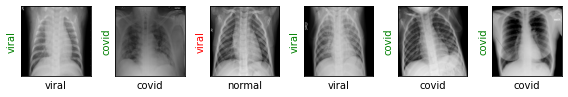

Starting epoch 15/20
0/127: Batch train Loss: 0.0061
1/127: Batch train Loss: 0.5035
2/127: Batch train Loss: 0.5368
3/127: Batch train Loss: 0.5424
4/127: Batch train Loss: 0.5434
5/127: Batch train Loss: 0.5736
6/127: Batch train Loss: 0.5751
7/127: Batch train Loss: 0.5882
8/127: Batch train Loss: 0.8498
9/127: Batch train Loss: 0.8556
10/127: Batch train Loss: 0.8563
11/127: Batch train Loss: 0.8748
12/127: Batch train Loss: 1.1004
13/127: Batch train Loss: 1.1010
14/127: Batch train Loss: 1.1067
15/127: Batch train Loss: 1.1101
16/127: Batch train Loss: 1.1587
17/127: Batch train Loss: 1.1769
18/127: Batch train Loss: 1.1784
19/127: Batch train Loss: 1.1861
20/127: Batch train Loss: 1.1872
21/127: Batch train Loss: 1.1888
22/127: Batch train Loss: 1.1908
23/127: Batch train Loss: 1.2095
24/127: Batch train Loss: 1.2320
25/127: Batch train Loss: 1.2644
26/127: Batch train Loss: 1.2845
27/127: Batch train Loss: 1.3143
28/127: Batch train Loss: 1.3487
29/127: Batch train Loss: 1.5612

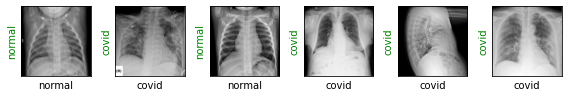

Starting epoch 16/20
0/127: Batch train Loss: 0.0019
1/127: Batch train Loss: 0.0033
2/127: Batch train Loss: 0.0185
3/127: Batch train Loss: 0.0226
4/127: Batch train Loss: 0.0232
5/127: Batch train Loss: 0.0282
6/127: Batch train Loss: 0.0315
7/127: Batch train Loss: 0.0347
8/127: Batch train Loss: 0.0464
9/127: Batch train Loss: 0.0473
10/127: Batch train Loss: 0.0582
11/127: Batch train Loss: 0.0594
12/127: Batch train Loss: 0.0619
13/127: Batch train Loss: 0.0651
14/127: Batch train Loss: 0.0726
15/127: Batch train Loss: 0.0735
16/127: Batch train Loss: 0.0769
17/127: Batch train Loss: 0.0797
18/127: Batch train Loss: 0.0826
19/127: Batch train Loss: 0.1223
20/127: Batch train Loss: 1.3853
21/127: Batch train Loss: 1.3870
22/127: Batch train Loss: 1.3938
23/127: Batch train Loss: 1.4441
24/127: Batch train Loss: 1.4453
25/127: Batch train Loss: 1.4465
26/127: Batch train Loss: 1.4491
27/127: Batch train Loss: 1.4566
28/127: Batch train Loss: 1.4843
29/127: Batch train Loss: 1.4907

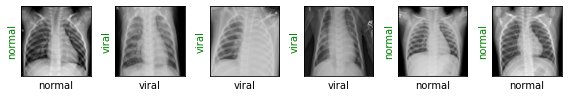

Starting epoch 17/20
0/127: Batch train Loss: 0.0011
1/127: Batch train Loss: 0.0030
2/127: Batch train Loss: 0.0061
3/127: Batch train Loss: 0.0079
4/127: Batch train Loss: 0.0099
5/127: Batch train Loss: 0.0438
6/127: Batch train Loss: 0.0697
7/127: Batch train Loss: 0.0711
8/127: Batch train Loss: 0.0731
9/127: Batch train Loss: 0.0972
10/127: Batch train Loss: 0.1280
11/127: Batch train Loss: 0.1760
12/127: Batch train Loss: 0.1842
13/127: Batch train Loss: 0.1891
14/127: Batch train Loss: 0.1924
15/127: Batch train Loss: 0.2165
16/127: Batch train Loss: 0.3191
17/127: Batch train Loss: 0.3227
18/127: Batch train Loss: 0.3403
19/127: Batch train Loss: 0.3409
20/127: Batch train Loss: 0.3469
21/127: Batch train Loss: 0.3510
22/127: Batch train Loss: 0.3515
23/127: Batch train Loss: 0.3523
24/127: Batch train Loss: 0.3573
25/127: Batch train Loss: 0.3591
26/127: Batch train Loss: 0.3833
27/127: Batch train Loss: 0.3881
28/127: Batch train Loss: 0.3889
29/127: Batch train Loss: 0.3918

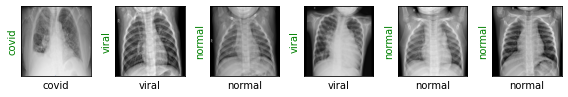

Starting epoch 18/20
0/127: Batch train Loss: 0.0279
1/127: Batch train Loss: 0.0414
2/127: Batch train Loss: 0.0419
3/127: Batch train Loss: 0.0445
4/127: Batch train Loss: 0.0486
5/127: Batch train Loss: 0.0493
6/127: Batch train Loss: 0.0519
7/127: Batch train Loss: 0.0549
8/127: Batch train Loss: 0.0568
9/127: Batch train Loss: 0.0580
10/127: Batch train Loss: 0.0837
11/127: Batch train Loss: 0.0857
12/127: Batch train Loss: 0.0901
13/127: Batch train Loss: 0.1357
14/127: Batch train Loss: 0.1373
15/127: Batch train Loss: 0.1379
16/127: Batch train Loss: 0.1385
17/127: Batch train Loss: 0.1419
18/127: Batch train Loss: 0.1459
19/127: Batch train Loss: 0.1990
20/127: Batch train Loss: 0.2067
21/127: Batch train Loss: 0.2074
22/127: Batch train Loss: 0.7713
23/127: Batch train Loss: 0.7875
24/127: Batch train Loss: 0.7889
25/127: Batch train Loss: 0.7944
26/127: Batch train Loss: 0.7996
27/127: Batch train Loss: 0.8058
28/127: Batch train Loss: 0.8088
29/127: Batch train Loss: 0.8100

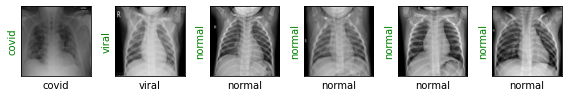

Starting epoch 19/20
0/127: Batch train Loss: 0.0050
1/127: Batch train Loss: 0.0056
2/127: Batch train Loss: 0.0204
3/127: Batch train Loss: 0.0644
4/127: Batch train Loss: 0.0650
5/127: Batch train Loss: 0.0687
6/127: Batch train Loss: 0.0699
7/127: Batch train Loss: 0.0708
8/127: Batch train Loss: 0.0718
9/127: Batch train Loss: 0.0737
10/127: Batch train Loss: 0.0769
11/127: Batch train Loss: 0.0774
12/127: Batch train Loss: 0.0778
13/127: Batch train Loss: 0.0804
14/127: Batch train Loss: 0.0844
15/127: Batch train Loss: 0.0851
16/127: Batch train Loss: 0.0918
17/127: Batch train Loss: 0.1120
18/127: Batch train Loss: 0.1183
19/127: Batch train Loss: 0.1186
20/127: Batch train Loss: 0.1200
21/127: Batch train Loss: 0.1207
22/127: Batch train Loss: 0.1265
23/127: Batch train Loss: 0.1283
24/127: Batch train Loss: 0.1288
25/127: Batch train Loss: 0.1298
26/127: Batch train Loss: 0.1654
27/127: Batch train Loss: 0.2713
28/127: Batch train Loss: 0.2717
29/127: Batch train Loss: 0.2798

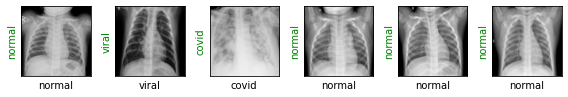

Starting epoch 20/20
0/127: Batch train Loss: 0.0022
1/127: Batch train Loss: 0.0039
2/127: Batch train Loss: 0.1188
3/127: Batch train Loss: 0.1194
4/127: Batch train Loss: 0.1197
5/127: Batch train Loss: 0.1227
6/127: Batch train Loss: 0.1257
7/127: Batch train Loss: 0.1279
8/127: Batch train Loss: 0.1336
9/127: Batch train Loss: 0.1350
10/127: Batch train Loss: 0.1371
11/127: Batch train Loss: 0.1374
12/127: Batch train Loss: 0.1391
13/127: Batch train Loss: 0.1394
14/127: Batch train Loss: 0.1403
15/127: Batch train Loss: 0.1407
16/127: Batch train Loss: 0.1469
17/127: Batch train Loss: 0.1502
18/127: Batch train Loss: 0.1521
19/127: Batch train Loss: 0.1526
20/127: Batch train Loss: 0.1588
21/127: Batch train Loss: 0.1682
22/127: Batch train Loss: 0.1712
23/127: Batch train Loss: 0.1740
24/127: Batch train Loss: 0.1743
25/127: Batch train Loss: 0.1746
26/127: Batch train Loss: 0.1880
27/127: Batch train Loss: 0.1987
28/127: Batch train Loss: 0.1998
29/127: Batch train Loss: 0.2005

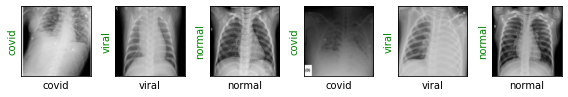

Training complete.
CPU times: user 1h 4min 53s, sys: 29.3 s, total: 1h 5min 22s
Wall time: 1h 5min 35s


In [41]:
%%time

train(epochs=20)

# Final Results

## Show the training/dev curve

Text(0.5, 0, '# epochs')

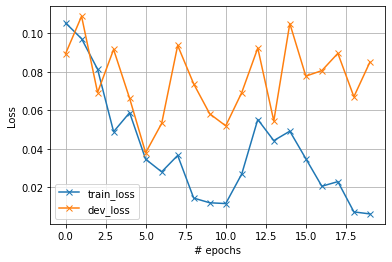

In [42]:
train_dev_loss_df = pd.DataFrame({'train_loss': train_losses, 'dev_loss': dev_losses})
ax = train_dev_loss_df.plot(marker='x', grid=True)
ax.set_ylabel('Loss')
ax.set_xlabel('# epochs')

Save to csv

In [43]:
train_dev_loss_df.to_csv('train_dev_loss_reference.csv')

## Mismatched examples analysis

In [44]:
resnet18.eval()
labels_all = []
preds_all = []
for i, (images, labels) in enumerate(dl_test):
    output = resnet18(images)
    _, preds = torch.max(output, 1)
    labels_all += labels
    preds_all += preds

comparison_df = pd.DataFrame(labels_all).rename(columns={0: 'labels'})
comparison_df['preds'] = [int(preds_all_el) for preds_all_el in preds_all]
comparison_df['misclassified'] = comparison_df.apply(lambda col: col['labels'] != col['preds'], axis=1)
comparison_df.head()

,labels,preds,misclassified
0,2,2,False
1,2,2,False
2,0,0,False
3,0,0,False
4,2,2,False


Display mismatched examples

In [45]:
comparison_df[comparison_df['misclassified'] == True]

,labels,preds,misclassified
66,1,0,True
78,0,2,True


Save to file

In [46]:
comparison_df.to_csv('misclassified_reference.csv')

## Test Accuracy

In [47]:
test_accuracy = sum(np.array(labels_all) == np.array(preds_all)) / len(preds_all)
print('Test accuracy is %.4f' % test_accuracy)

Test accuracy is 0.9778


In [48]:
training_dev_accuracy_df = pd.DataFrame({'training_accuracy': train_accuracies, 'dev_accuracy': dev_accuracies})
training_dev_accuracy_df.tail()

,training_accuracy,dev_accuracy
15,0.990777,0.966667
16,0.997365,0.955556
17,0.994730,0.955556
18,1.000000,0.966667
19,1.000000,0.966667


Save to csv file

In [49]:
training_dev_accuracy_df.to_csv('training_dev_accuracy_reference.csv')

# Confusion Matrix

In [50]:
resnet18.eval() # set model to eval phase

nb_classes = 3

with torch.no_grad():
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    for i, (images, labels) in enumerate(dl_test):
        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
          confusion_matrix[t.long(), p.long()] += 1

confusion_matrix_df = pd.DataFrame(confusion_matrix.numpy(), columns=class_names, index=class_names)
confusion_matrix_df

,normal,viral,covid
normal,29.0,0.0,1.0
viral,1.0,29.0,0.0
covid,0.0,0.0,30.0


Save to csv

In [51]:
confusion_matrix_df.to_csv('confusion_matrix_reference.csv')